The purpose of this project is to examine the determinants of mutual fund inflows (ie. new money flowing into a mutual fund) over monthly observations. Sirri and Tufano (1998) show that the primary driver of fund flows is performance.

In [2]:
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:20,.4f}'.format

Import the first file, tna (total net assets) that contains dates, mutual fund size, and mutual fund returns. I clean up errors in the data by removing 'R' and 'T' values. I then remove observations with size less than 0 and returns below -100%, both are not possible and are therefore errors in the data.

In [3]:
#import returns and size file

tna = pd.read_csv('mret_tna.csv',parse_dates=['caldt'],na_values=['R','T'])
tna = tna[tna['mtna'] >= 0]
tna = tna[tna['mret'] > -1]


The two variables of interest are mtna = monthly total net assets (mutual fund size) and mret = monthly returns. 

In [4]:
tna[['mtna','mret']].describe()

###HOW DO I DESCRIBE MULTIPLE COLUMNS? HOW DO I SUPRESS SCIENTIFIC NOTATION?

,mtna,mret
count,"4,720,137.0000","4,720,137.0000"
mean,538.2051,0.0050
std,"3,118.5113",0.0413
min,0.0000,-0.9802
25%,4.9000,-0.0074
50%,36.5000,0.0042
75%,210.4000,0.0213
max,"306,670.6000",10.8966


Import the second file for this analysis.
    crsp_fundno = mutual fund share class
    caldt = monthly observation date
    per_cash = percent of cash held by the mutual fund share class
    crsp_cl_grp = mutual fund portfolio (the ID used to aggregate the multiple shareclasses)
    exp_ratio = expense ratio as a decimal
    crsp_obj_cd = mutual fund objective code

In [5]:
#import mf characteristics file 

mf_char = pd.read_csv('fund_char.csv',parse_dates=['caldt'])
mf_char = mf_char.dropna(subset=['crsp_cl_grp'])
mf_char['crsp_cl_grp'] = mf_char['crsp_cl_grp'].astype(np.int64)
mf_char.head()

,summary_period2,crsp_fundno,caldt,per_cash,crsp_portno,crsp_cl_grp,ncusip,exp_ratio,crsp_obj_cd
0,AQ,105,2004-12-31,nan,"1,000,880.0000",2000026,028837102,0.0285,EF
1,AQ,105,2005-12-30,0.0000,"1,000,880.0000",2000026,028837102,0.0272,EF
2,AQ,105,2006-12-29,0.0000,"1,000,880.0000",2000026,028837102,0.0258,EF
3,AQ,105,2007-12-31,0.0000,"1,000,880.0000",2000026,028837102,0.0259,EF
4,AQ,105,2008-12-31,0.8400,"1,000,880.0000",2000026,028837102,0.0256,EF


drop unused data to clean dataset for merging

In [6]:
#drop extra columns not needed for analysis

mf_char2 = mf_char.drop(['summary_period2','ncusip','crsp_portno'], axis=1)
mf_char2.head()

,crsp_fundno,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd
0,105,2004-12-31,nan,2000026,0.0285,EF
1,105,2005-12-30,0.0000,2000026,0.0272,EF
2,105,2006-12-29,0.0000,2000026,0.0258,EF
3,105,2007-12-31,0.0000,2000026,0.0259,EF
4,105,2008-12-31,0.8400,2000026,0.0256,EF


Create a ym variable that drops the day from the date. This allows for easier merging by avoiding instances such as 2004-12-31 trying to merge with 2004-12-30. In both cases the obvservation is for December 2004, but happened to occur on different days.

In [7]:
#create ym variables for analysis at month level
tna['ym'] = pd.to_datetime(tna['caldt']).dt.to_period('M')
tna_ym = tna.drop('caldt', axis=1)
tna_ym.head()

,crsp_fundno,mtna,mret,ym
48,105,51.5000,0.0361,2004-01
49,105,51.5000,-0.0028,2004-02
50,105,52.1000,-0.0038,2004-03
51,105,49.7000,-0.0483,2004-04
52,105,50.5000,0.0249,2004-05


repeat the same process as above with the second file so that both contain the ym variable for merging

In [8]:
mf_char2['ym'] = pd.to_datetime(mf_char2['caldt']).dt.to_period('M')
mf_ym = mf_char2
mf_ym.head()

,crsp_fundno,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd,ym
0,105,2004-12-31,nan,2000026,0.0285,EF,2004-12
1,105,2005-12-30,0.0000,2000026,0.0272,EF,2005-12
2,105,2006-12-29,0.0000,2000026,0.0258,EF,2006-12
3,105,2007-12-31,0.0000,2000026,0.0259,EF,2007-12
4,105,2008-12-31,0.8400,2000026,0.0256,EF,2008-12


merge the mutual fund returns and size with the other mutual fund characteristics my fund shareclass (crsp_fundno) and ym. Require all observations to occur in both files.

In [9]:
#merge tna_ym and mf_ym by fundno & ym - how = inner (ie. must have data in both sets)
tna_ret = pd.merge(tna_ym,mf_ym,on=['crsp_fundno','ym'],how='inner')

tna_ret['mret']
tna_ret.head()

,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd
0,105,52.4000,0.0318,2004-12,2004-12-31,nan,2000026,0.0285,EF
1,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF
2,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF
3,105,57.9000,-0.0042,2007-12,2007-12-31,0.0000,2000026,0.0259,EF
4,105,25.5000,0.0607,2008-12,2008-12-31,0.8400,2000026,0.0256,EF


Fill in NaN valules of expense ratio and cash with 0. 
Sort files by mutual fund portfolio (crsp_cl_grp) and date (ym) to begin aggregating data up from the shareclass level to the portfolio level.
Forward fill missing crsp_obj_cd observations by mutual fund portfolio.

In [10]:
#clean NaN values for cash and exp ratio, forward fill objective codes by crsp_cl_grp
tna_ret2 = tna_ret.copy()
tna_ret2['per_cash'].fillna(0, inplace=True)
tna_ret2['exp_ratio'].fillna(0, inplace=True)
tna_ret2.sort_values(['crsp_cl_grp','ym'],inplace=True)

tna_ret2['obj'] = tna_ret2.groupby('crsp_cl_grp')['crsp_obj_cd'].fillna(method='ffill')
tna_ret2.drop('crsp_obj_cd', axis=1, inplace=True)
#tna_ret2['obj'] = tna_ret2.groupby('crsp_cl_grp')['crsp_obj_cd'].apply(lambda x: x.ffill())

tna_ret2.head(10)

,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,obj
0,105,52.4000,0.0318,2004-12,2004-12-31,0.0000,2000026,0.0285,EF
279641,45769,2.3000,0.0327,2004-12,2004-12-31,0.0000,2000026,0.0000,EF
1,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF
279642,45769,4.1000,0.0088,2005-12,2005-12-30,0.0000,2000026,0.0172,EF
2,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF
279643,45769,4.8000,0.0144,2006-12,2006-12-29,0.0000,2000026,0.0158,EF
3,105,57.9000,-0.0042,2007-12,2007-12-31,0.0000,2000026,0.0259,EF
279644,45769,4.9000,-0.0038,2007-12,2007-12-31,0.0000,2000026,0.0159,EF
4,105,25.5000,0.0607,2008-12,2008-12-31,0.8400,2000026,0.0256,EF
279645,45769,2.3000,0.0611,2008-12,2008-12-31,0.8400,2000026,0.0156,EF


Calculate total mutual fund portfolio size each month as the total mtna across all shareclasses within a portfolio.

In [11]:
#calculate portfolio tna
portno_size = tna_ret2.groupby(['crsp_cl_grp','ym'],as_index=False).agg({'mtna':'sum'})
portno_size.rename(columns={'mtna':'portno_tna'},inplace=True) #update tna_portno in place or replace the file
portno_size.head()

,crsp_cl_grp,ym,portno_tna
0,2000026,2004-12,54.7000
1,2000026,2005-12,55.6000
2,2000026,2006-12,62.1000
3,2000026,2007-12,62.8000
4,2000026,2008-12,27.8000


Merge the portfolio tna with the original shareclass data to allow for a weighted average of mutual fund characeristics.

In [12]:
#merge portfolio tna with fundno data to allow for weight calculations
port1 = pd.merge(tna_ret2,portno_size,on=['crsp_cl_grp','ym'],how='inner')
port1.head()


,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,obj,portno_tna
0,105,52.4000,0.0318,2004-12,2004-12-31,0.0000,2000026,0.0285,EF,54.7000
1,45769,2.3000,0.0327,2004-12,2004-12-31,0.0000,2000026,0.0000,EF,54.7000
2,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF,55.6000
3,45769,4.1000,0.0088,2005-12,2005-12-30,0.0000,2000026,0.0172,EF,55.6000
4,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF,62.1000


calculate what weight each shareclass equals within the mutual fund portfolio, then calculate the shareclass weighted values of cash, expense ratios, and returns.

In [13]:
#calculate weights and weight * vars
port1['wgt'] = port1['mtna'] / port1['portno_tna']
port1['port_cash'] = port1['per_cash'] * port1['wgt']
port1['port_exp'] = port1['exp_ratio'] * port1['wgt']
port1['port_ret'] = port1['mret'] * port1['wgt']
port1.head()

,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,obj,portno_tna,wgt,port_cash,port_exp,port_ret
0,105,52.4000,0.0318,2004-12,2004-12-31,0.0000,2000026,0.0285,EF,54.7000,0.9580,0.0000,0.0273,0.0305
1,45769,2.3000,0.0327,2004-12,2004-12-31,0.0000,2000026,0.0000,EF,54.7000,0.0420,0.0000,0.0000,0.0014
2,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF,55.6000,0.9263,0.0000,0.0252,0.0135
3,45769,4.1000,0.0088,2005-12,2005-12-30,0.0000,2000026,0.0172,EF,55.6000,0.0737,0.0000,0.0013,0.0006
4,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF,62.1000,0.9227,0.0000,0.0238,0.0123


sum the weight x variable measures created in the prior step. aggregate them across each portfolio ym observations. These become the portfolio characteristics created from each of the individual shareclass observations.

In [14]:
port2 = port1.groupby(['crsp_cl_grp','ym'],as_index=False).agg({'port_cash':'sum','port_exp':'sum','port_ret':'sum'})
port2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret
0,2000026,2004-12,0.0000,0.0273,0.0319
1,2000026,2005-12,0.0000,0.0265,0.0141
2,2000026,2006-12,0.0000,0.0250,0.0135
3,2000026,2007-12,0.0000,0.0251,-0.0041
4,2000026,2008-12,0.8400,0.0248,0.0607


merge the portfolio variables for cash, expense ratio, and return with the file containing mutual fund objective and portfolio tna. this will result in many repeating observations for each portfolio due to the existence of multiple shareclasses in the port1 file. create a file that identifies the first observations of each portfolio month and retain those observations.

In [15]:
#merge portfolio weight vars with original file to keep crsp_obj_cd
port3 = port1[['crsp_cl_grp','ym','obj','portno_tna']]
port4 = port3.groupby(['crsp_cl_grp','ym']).cumcount()==0
port5 = port3[port4]

port6 = pd.merge(port2,port5,on=['crsp_cl_grp','ym'],how='inner')
port6.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna
0,2000026,2004-12,0.0000,0.0273,0.0319,EF,54.7000
1,2000026,2005-12,0.0000,0.0265,0.0141,EF,55.6000
2,2000026,2006-12,0.0000,0.0250,0.0135,EF,62.1000
3,2000026,2007-12,0.0000,0.0251,-0.0041,EF,62.8000
4,2000026,2008-12,0.8400,0.0248,0.0607,EF,27.8000


Repeat the aggregation process for each mutual fund investment objective. The focus in on calculating the objective size aggregated across all mutual funds within an objective and then determining the objective size and performance.

In [16]:
#calculate object level performance
obj1 = port6.groupby(['obj','ym'],as_index=False).agg({'portno_tna':'sum'})
obj1.rename(columns={'portno_tna':'obj_tna'},inplace=True)
obj1.head()

,obj,ym,obj_tna
0,EDCI,2004-12,"14,922.8000"
1,EDCI,2005-12,"14,428.4000"
2,EDCI,2006-12,"16,657.6000"
3,EDCI,2007-12,"14,580.6000"
4,EDCI,2008-12,"7,014.5000"


In [17]:
#merge objective tna with portfolio data to allow for weight calculations
obj2 = pd.merge(port6,obj1,on=['obj','ym'],how='inner')
obj2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna
0,2000026,2004-12,0.0000,0.0273,0.0319,EF,54.7000,"525,629.9000"
1,2000271,2004-12,0.0000,0.0076,0.0431,EF,677.5000,"525,629.9000"
2,2000476,2004-12,31.5500,0.0232,0.0098,EF,70.7000,"525,629.9000"
3,2000486,2004-12,7.8600,0.0207,0.0396,EF,289.7000,"525,629.9000"
4,2000500,2004-12,6.5600,0.0253,0.0426,EF,22.3000,"525,629.9000"


In [18]:
#calculate weights and weight * vars
obj2['obj_wgt'] = obj2['portno_tna'] / obj2['obj_tna']
obj2['obj_wgt_ret'] = obj2['port_ret'] * obj2['obj_wgt']
obj2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_wgt,obj_wgt_ret
0,2000026,2004-12,0.0000,0.0273,0.0319,EF,54.7000,"525,629.9000",0.0001,0.0000
1,2000271,2004-12,0.0000,0.0076,0.0431,EF,677.5000,"525,629.9000",0.0013,0.0001
2,2000476,2004-12,31.5500,0.0232,0.0098,EF,70.7000,"525,629.9000",0.0001,0.0000
3,2000486,2004-12,7.8600,0.0207,0.0396,EF,289.7000,"525,629.9000",0.0006,0.0000
4,2000500,2004-12,6.5600,0.0253,0.0426,EF,22.3000,"525,629.9000",0.0000,0.0000


After aggregating to the objective level, calculate the prior months objective performance (ie. lagged 1 month performance).

In [19]:
obj3 = obj2.groupby(['obj','ym'],as_index=False).agg({'obj_wgt_ret':'sum'})
obj3.rename(columns={'obj_wgt_ret':'obj_ret'},inplace=True)

obj3['lag_obj_ret'] = obj3.groupby('obj')['obj_ret'].shift()
obj3.dropna(subset=['lag_obj_ret'],inplace=True)

obj3.head()

,obj,ym,obj_ret,lag_obj_ret
1,EDCI,2005-12,0.0042,0.0450
2,EDCI,2006-12,0.0109,0.0042
3,EDCI,2007-12,-0.0009,0.0109
4,EDCI,2008-12,0.0509,-0.0009
5,EDCI,2009-12,0.0761,0.0509


In [20]:
obj4 = pd.merge(obj2,obj3,on=['obj','ym'],how='left')
obj4 = obj4.drop(['obj_wgt','obj_wgt_ret'], axis=1)
obj4.dropna(subset=['lag_obj_ret'],inplace=True)
obj4.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret
406,2000026,2005-12,0.0000,0.0265,0.0141,EF,55.6000,"681,732.9000",0.0451,0.0400
407,2000271,2005-12,0.4400,0.0078,0.0551,EF,259.0000,"681,732.9000",0.0451,0.0400
408,2000476,2005-12,9.4491,0.0225,0.0184,EF,170.1000,"681,732.9000",0.0451,0.0400
409,2000486,2005-12,0.0000,0.0202,0.0307,EF,435.4000,"681,732.9000",0.0451,0.0400
410,2000500,2005-12,5.6400,0.0248,0.0333,EF,32.7000,"681,732.9000",0.0451,0.0400


calculate the variable of interest, mutual fund percentage flows. this is a measure of how much new money enters a mutual fund over the course of a month after accounting for the performance of the fund.

ie. if a mutual fund is $10 this month and $20 next month while having returns of 40% over the month, the fund grew by $10, but $4 of that is due to the returns earned by the fund, so the new fund flows amount to $6.

In [21]:
#calculate fund flows as [tna(t) - [tna(t-1) * 1+port_ret] ]/ portno_tna(t-1)
flow = obj4.copy()
flow.sort_values(['crsp_cl_grp','ym'],inplace=True)
flow['l_port_tna'] = flow.groupby('crsp_cl_grp')['portno_tna'].shift()
flow['flow'] = (flow['portno_tna'] - flow['l_port_tna'] * (1 + flow['port_ret'])) / flow['l_port_tna']
flow.dropna(subset=['flow'],inplace=True)

drop mutual funds not considered domestic equity (ie. 'ED' objective codes).

In [22]:
#retain only ED mutual funds
flow2 = flow.copy()

flow2['obj_2'] = flow2['obj'].str.slice(0,2)

#flow2['obj_2'] = flow2['obj'].astype(str).str[:2]
flow2 = flow2[flow2['obj_2'] == 'ED']

flow2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,obj_2
12239,2000035,2006-12,2.0600,0.0110,-0.0007,EDYG,433.5000,"1,418,682.1000",0.0046,0.0079,423.4000,0.0245,ED
12240,2000137,2006-12,0.0000,0.0124,-0.0087,EDYG,423.1000,"1,418,682.1000",0.0046,0.0079,414.8000,0.0288,ED
38199,2000137,2007-12,0.0000,0.0111,0.0054,EDYG,489.7000,"1,634,767.9000",-0.0033,0.0046,423.1000,0.1520,ED
39379,2000137,2008-12,3.9000,0.0111,0.0249,EDYG,245.8000,"1,114,048.0000",0.0237,-0.0033,489.7000,-0.5230,ED
40980,2000137,2009-12,0.4900,0.0101,0.0213,EDYG,229.8000,"1,444,846.4000",0.0319,0.0237,245.8000,-0.0864,ED


create a measure of lagged monthly returns

In [23]:
#create 1-month lagged returns (portno)

flow2.sort_values(['crsp_cl_grp','ym'],inplace=True)
flow2['lag_ret'] = flow2.groupby('crsp_cl_grp')['port_ret'].shift()
flow2.dropna(subset=['lag_ret'],inplace=True)

flow2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,obj_2,lag_ret
38199,2000137,2007-12,0.0000,0.0111,0.0054,EDYG,489.7000,"1,634,767.9000",-0.0033,0.0046,423.1000,0.1520,ED,-0.0087
39379,2000137,2008-12,3.9000,0.0111,0.0249,EDYG,245.8000,"1,114,048.0000",0.0237,-0.0033,489.7000,-0.5230,ED,0.0054
40980,2000137,2009-12,0.4900,0.0101,0.0213,EDYG,229.8000,"1,444,846.4000",0.0319,0.0237,245.8000,-0.0864,ED,0.0249
38200,2000234,2007-12,-0.1200,0.0066,-0.0165,EDYG,841.1000,"1,634,767.9000",-0.0033,0.0046,676.5000,0.2598,ED,0.0168
39380,2000234,2008-12,2.7300,0.0083,0.0375,EDYG,312.1000,"1,114,048.0000",0.0237,-0.0033,841.1000,-0.6664,ED,-0.0165


clean any outlier observations. if fund flows greater than 500%, if fund flows less than 100%, and if returns greater than 100% then delete observations.

In [31]:
#create descriptive tables and figures

#general descriptive statistics of variables

flow2 = flow2[flow2['flow'] < 5]
flow2 = flow2[flow2['flow'] > -1]
flow2 = flow2[flow2['port_ret'] < 1]
    
flow2.describe()

,crsp_cl_grp,port_cash,port_exp,port_ret,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,lag_ret
count,"41,242.0000","41,242.0000","41,242.0000","41,242.0000","41,242.0000","41,242.0000","41,242.0000","41,242.0000","41,242.0000","41,242.0000","41,242.0000"
mean,"2,009,156.0598",5.3687,-0.7776,0.0131,"1,574.4716","1,086,062.2162",0.0134,0.0137,"1,447.4407",0.1496,0.0137
std,"6,197.1196",21.5274,7.8795,0.0368,"8,928.4894","871,506.7552",0.0282,0.0298,"7,696.3853",0.5897,0.0391
min,"2,000,137.0000",-525.1100,-99.0000,-0.6925,0.1000,"2,308.4000",-0.1690,-0.1690,0.1000,-0.9980,-0.6925
25%,"2,004,606.0000",0.0400,0.0025,-0.0047,57.6000,"282,270.5000",-0.0043,-0.0043,55.3000,-0.1276,-0.0052
50%,"2,008,521.0000",1.1700,0.0091,0.0117,234.8500,"788,998.1000",0.0114,0.0114,222.1000,0.0410,0.0127
75%,"2,012,657.5000",3.5900,0.0124,0.0286,898.4000,"1,905,474.0000",0.0237,0.0270,847.8750,0.2707,0.0302
max,"2,061,756.0000",410.0700,0.7267,0.4682,"662,577.0000","2,573,961.4000",0.1884,0.1884,"498,117.1000",4.9863,1.3818


examine the data visually to see if anything looks out of place before deciding what else, if anyting, to do with outliers.

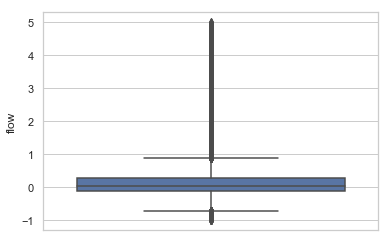

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style='whitegrid')

_ = sns.boxplot(y=flow2['flow'])
plt.show()

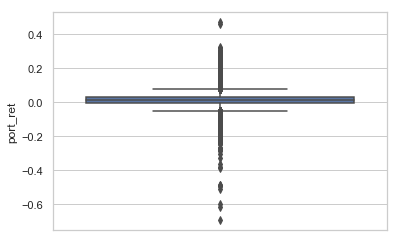

In [33]:
_ = sns.boxplot(y=flow2['port_ret'])
plt.show()

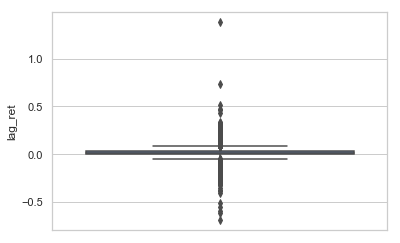

In [34]:
_ = sns.boxplot(y=flow2['lag_ret'])
plt.show()

start some exploratory analysis by looking at correlations between variables. The expectation is that flows will be strongly correlated with current and prior month portfolio returns.

In [54]:
#correlation of variables
flow2.corr()

,crsp_cl_grp,port_cash,port_exp,port_ret,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,lag_ret
crsp_cl_grp,1.0000,0.0497,-0.0269,-0.1045,-0.0427,0.0805,-0.1196,-0.1100,-0.0499,0.1414,-0.0916
port_cash,0.0497,1.0000,0.0137,-0.1437,-0.0304,-0.1585,-0.1321,-0.1709,-0.0317,-0.0196,-0.1623
port_exp,-0.0269,0.0137,1.0000,0.0117,-0.0254,-0.0985,0.0051,0.0037,-0.0225,-0.0232,0.0102
port_ret,-0.1045,-0.1437,0.0117,1.0000,-0.0087,-0.0886,0.7746,0.1424,-0.0149,0.0460,0.1309
portno_tna,-0.0427,-0.0304,-0.0254,-0.0087,1.0000,0.0510,-0.0136,-0.0092,0.9826,0.0062,-0.0070
obj_tna,0.0805,-0.1585,-0.0985,-0.0886,0.0510,1.0000,-0.1063,-0.0884,0.0496,0.0424,-0.0729
obj_ret,-0.1196,-0.1321,0.0051,0.7746,-0.0136,-0.1063,1.0000,0.1556,-0.0206,0.0692,0.1333
lag_obj_ret,-0.1100,-0.1709,0.0037,0.1424,-0.0092,-0.0884,0.1556,1.0000,-0.0144,0.0533,0.7459
l_port_tna,-0.0499,-0.0317,-0.0225,-0.0149,0.9826,0.0496,-0.0206,-0.0144,1.0000,-0.0230,-0.0113
flow,0.1414,-0.0196,-0.0232,0.0460,0.0062,0.0424,0.0692,0.0533,-0.0230,1.0000,0.0512


graph the relationship between returns, lag returns, objective returns, and objective lag returns with fund flows.

Text(0.5, 1.0, 'Portfolio Rets')

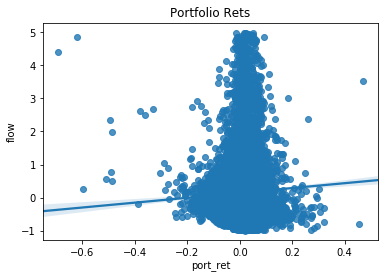

In [56]:
#graph relation between flow and (1) port_ret (2) lag_ret (3) obj_ret (4) lag_obj_ret (5) size

sns.regplot(x='port_ret',y='flow',data=flow2).set_title('Portfolio Rets')

Text(0.5, 1.0, 'Lag Rets')

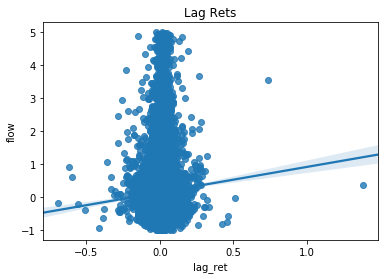

In [57]:
sns.regplot(x='lag_ret',y='flow',data=flow2).set_title('Lag Rets')

Text(0.5, 1.0, 'Obj Rets')

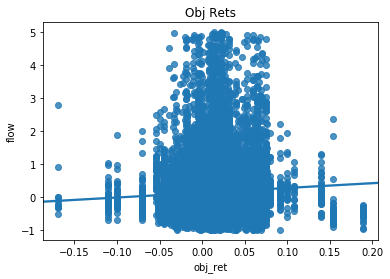

In [28]:
sns.regplot(x='obj_ret',y='flow',data=flow2).set_title('Obj Rets')

Text(0.5, 1.0, 'Lag Obj Rets')

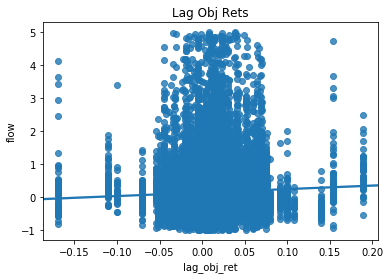

In [29]:
sns.regplot(x='lag_obj_ret',y='flow',data=flow2).set_title('Lag Obj Rets')

explore the plots using subplots. these are not that informative, but i found it good practice.

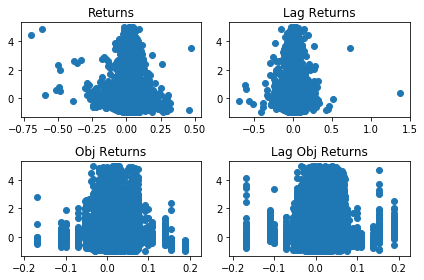

In [30]:
import matplotlib.pyplot as plt

plt.subplot(2,2,1)
plt.scatter(x='port_ret',y='flow',data=flow2)
plt.title('Returns')
plt.subplot(2,2,2)
plt.scatter(x='lag_ret',y='flow',data=flow2)
plt.title('Lag Returns')
plt.subplot(2,2,3)
plt.scatter(x='obj_ret',y='flow',data=flow2)
plt.title('Obj Returns')
plt.subplot(2,2,4)
plt.scatter(x='lag_obj_ret',y='flow',data=flow2)
plt.title('Lag Obj Returns')

plt.tight_layout()
plt.show()

the relationship between performance and fund flows should be positive, with the top performing funds experiencing the benefit of new money. i rank funds each month into 10 groups by fund performance. within each of the ten groups i calculate the average fund flows. 

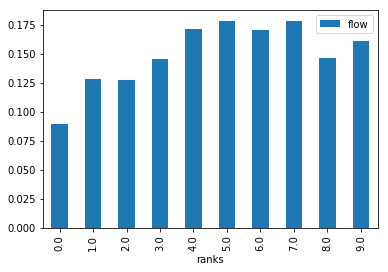

In [64]:
#RANKS AND AVERAGE FLOW

flow3 = flow2.copy()
flow3['ranks'] = flow3.groupby('ym')['port_ret'].transform(pd.qcut, 10, labels=False)
#flow3.groupby(['ranks']).agg({'port_ret':'mean'})
flow3.groupby(['ranks']).agg({'flow':'mean'}).plot(kind='bar')


The results up to this point indicate that investors observe positive performance in mutual funds and invest in those funds. They also observe mutual fund objectives that outperform and invest in those funds as well. This is consistent with investors trying to move money into outperforming mutual funds.
